# import

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def extend_line(point1, point2, extend_direction):
    # Calculate the slope of the line
    slope = (point2[1] - point1[1]) / (point2[0] - point1[0])

    # Calculate the new coordinates
    if extend_direction == "positive":
        new_x = point2[0] + 0.4 * (point2[0] - point1[0])
        new_y = point2[1] + 0.4 * (point2[1] - point1[1])
    elif extend_direction == "negative":
        new_x = point1[0] - 0.3 * (point2[0] - point1[0])
        new_y = point1[1] - 0.3 * (point2[1] - point1[1])
    else:
        raise ValueError("Invalid extend direction. Must be 'positive' or 'negative'.")

    return [(point1[0], point1[1]), (point2[0], point2[1]), (new_x, new_y)]



# set paths

In [18]:

atlas_path = os.getcwd() + r'\reference_images\reference_25um_inverted_cropped.tif'
cp_image_path = os.getcwd() + r'\reference_images\sagtial_reference_25um_inverted.tif'
file_path = os.getcwd() + r'\example_data\probe_positions.txt'

#load in probe tip location data
coords = pd.read_csv(file_path, header=0)

# define coordinates and atlas slices

In [47]:
# the data has a column group that is used to color the fibers, define those colours:
colours_ = ['buffer','#BE575F','#1A79B6','#4F4F4F','k']

# for coronal data select number of slices to show, rows and cols
n_images = 3
rows = 1
cols = 3


# add the striatum limits
z_limits = [1, 130]
y_limits = [60, 271]

# read the file of points (xy positions of the start and end of each probe)
X1 = coords.x1
Y1 = coords.y1
Z1 = coords.z1
X2 = coords.x2
Y2 = coords.y2
Z2 = coords.z2
Animal_Name = coords.Mouse_name

# select only the fibers used in the analysis
X1 = np.array(list(X1)).astype(float)
Y1 = np.array(list(Y1)).astype(float)
Z1 = np.array(list(Z1)).astype(float)
X2 = np.array(list(X2)).astype(float)
Y2 = np.array(list(Y2)).astype(float)
Z2 = np.array(list(Z2)).astype(float)
Animal_Name = np.array(list(Animal_Name))

# read atlas get slice numbers
atlas = Image.open(atlas_path)
h,w = np.shape(atlas)
# decide on the number of images
step = int(np.floor((z_limits[1] - z_limits[0]) / n_images))
sl_list = list(range(z_limits[0], z_limits[1], step))
sl_list = sl_list[-n_images:]

# Mirror all to the right hemisphere
atlas_mid_point = w/2
for i in range(len(X1)):
    if X1[i] < atlas_mid_point:
        dist_to_center = atlas_mid_point - X1[i]
        X1[i] = atlas_mid_point + dist_to_center
for i in range(len(X2)):
    if X2[i] < atlas_mid_point:
        dist_to_center = atlas_mid_point - X2[i]
        X2[i] = atlas_mid_point + dist_to_center
        
for i in range(len(X1)):
    X1[i] = X1[i]-7
for i in range(len(Y2)):
    X2[i] = X2[i]-7

groups = list(coords.group.values)

# plot sagital

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29716\3924601514.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(a, fontsize=18)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_29716\3924601514.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(a, fontsize=18)


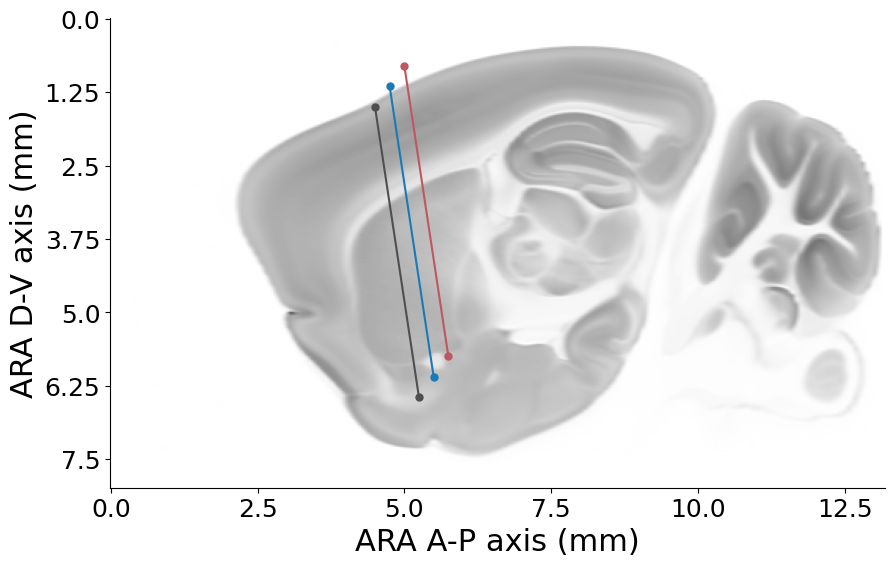

In [48]:


# make the plot
fig, ax = plt.subplots(1, 1, figsize=[10,10])
# show striatum outline
str_im = Image.open(cp_image_path)
ax.imshow(str_im, cmap='gray',alpha = 0.6)

for i in range(len(X1)):
    new_point = extend_line((Z1[i],Z2[i]),(Y1[i],Y2[i]),'positive')
#     ax.plot((Z1[i], Z2[i]),(Y1[i],Y2[i]), '-', color=colours_[groups[i]],
#             alpha=1, markersize=10, markeredgewidth=1)
    if not groups[i] == 4:
        ax.plot(new_point[0], new_point[-1], 'o-', color=colours_[groups[i]],
                alpha=1, markersize=5, markeredgewidth=1)

    
    
# add limits of striatum
a=ax.get_xticks().tolist()
a= [25 * a[i] / 1000 for i in range(len(a))]
ax.set_xticklabels(a, fontsize=18)
a=ax.get_yticks().tolist()
a= [25 * a[i] / 1000 for i in range(len(a))]
ax.set_yticklabels(a, fontsize=18)
ax.set_xlabel('ARA A-P axis (mm)', fontsize=22)
ax.set_ylabel('ARA D-V axis (mm)', fontsize=22)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)



# plot coronal

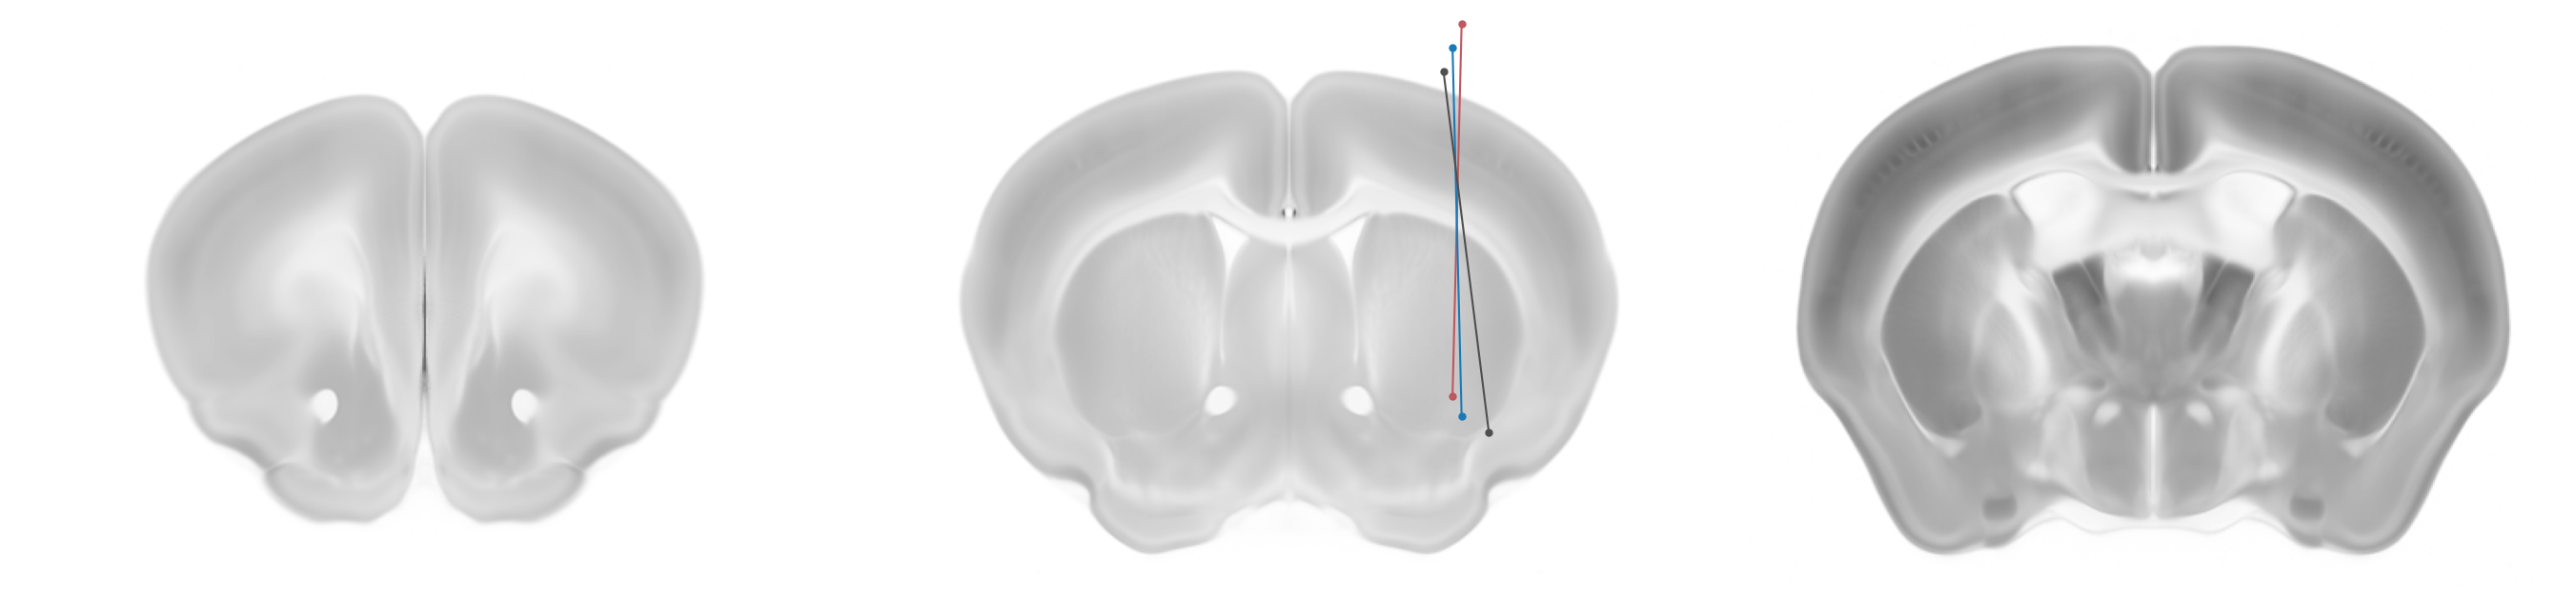

In [50]:
# plot the fibers in the slices
fig2, axs = plt.subplots(rows, cols, figsize=[cols * w/50, rows * h/50])
axs = axs.ravel()
for c,i in enumerate(sl_list):
    atlas.seek(i)
    axs[c].imshow(atlas, cmap='gray',alpha = 0.6)
    axs[c].axis('off')
# fig2.subplots_adjust(wspace=0, hspace=0)
fig2.tight_layout()

# plot the fibers
# so save space the front part of the atlas was cropped off, 151 images were removed so i need to account for this in the z position 
cropped_atlas = 151
for c,x in enumerate(Z1-cropped_atlas):
    # find the index of the slice that this point is closest to
    templist = [np.abs(b - x) for b in sl_list]
    idx = np.argmin(templist)
    new_point = extend_line((X1[c],X2[c]),(Y1[c],Y2[c]),'positive')
    if not groups[c] == 4:
        axs[idx].plot(new_point[0], new_point[-1], 'o-', color=colours_[groups[c]],
                alpha=1, markersize=5, markeredgewidth=1)
        
